# 딥러닝을 이용한 악기 소리 분류

### 학습 데이터
가짜 악기(virtual instrument, 가상 악기) 데이터는 쉽게 구할 수 있고 많은 편임  
MIDI 표준에는 128개의 악기가 등록되어있음

2초 간격으로 128종 악기별 50개의 음, 46개의 타악기 소리 (https://bab2min.tistory.com/642)

.wav는 매 순간의 음압을 측정해 그 수치를 저장한 형태  
-> 음악을 분석하기에 적합하지 않음  
-> 음의 높이와 세기를 듣는것이지 음압을 듣는 것이 아니기 때문

푸리에 변환을 이용해 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야 할 필요가 있음 (Constant-Q 변환 사용)

### Constant-Q 변환
주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에 음악 처리에 푸리에 변환보다 유리하다고 알려져 있음

In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

In [ ]:
spt = []
ins = []
duration_offset = 0
# MIDI 표준 128
for instrument, note in itertools.product(range(128), range(50)): # 데카르트 곱(cartesian product)
    y, sr = librosa.load("./GeneralMidi.wav", sr=None, offset=duration_offset, duration=2.0)
    duration_offset += 2
    # 데이터 증강을 위해 화이트 노이즈를 섞은 버전도 함께 변환
    # 옥타브당 24단계로, 총 7옥타브로 변환
    for r in (0, 1e-4, 1e-3):
        ret = librosa.cqt(y+((np.random.rand(*y.shape)-0.5)*r if r else 0),
                          sr,
                          hop_length=1024,
                          n_bins=24*7,
                          bins_per_octave=24)
        # 위상 x, 세기만 관심 있으므로 절대값을 취함
        ret = np.abs(ret)
        # 스펙토그램 저장
        spt.append(ret)
        # 악기 번호와 음 높이를 저장
        ins.append((instrument, 38+note))
# 타악기 46
for note in range(46):
    y, sr = librosa.load('./GeneralMidi.wav', sr=None, offset=duration_offset, duration=2.0)
    duration_offset += 2
    for r, s in itertools.product([0, 1e-5, 1e-4, 1e-3], range(7)):
        ret = librosa.cqt(y+((np.random.rand(*y.shape) - 0.5)*r*s if r else 0),
                          sr,
                          hop_length=1024,
                          n_bins=24*7,
                          bins_per_octave=24)
        ret = np.abs(ret)
        spt.append(ret)
        ins.append((note + 128, 0))
    
spt = np.array(spt, np.float32)
ins = np.array(ins, np.int16)

np.savez("cqt.npz", sepc=spt, instr=ins)    

### Modeling
CQT를 스펙토그램으로 그리면 X축은 시간, Y축은 주파수 대역  
-> 2차원 그림으로 표현 가능

In [11]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(168, 87, 1)))
model.add(MaxPool2D((2, 2), (2, 2), padding="valid"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPool2D((2, 2), (2, 2), padding="same"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(174, activation="softmax"))

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 166, 85, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 83, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 81, 40, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 20, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 41, 20, 32)        0         
                                                                 
 flatten (Flatten)           (None, 26240)            

In [12]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ["accuracy"]
)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss", restore_best_weights=True)

### Train

In [4]:
npz = np.load('cqt.npz')
x = npz['sepc'] # spec
y = npz['instr']

In [20]:
x = np.expand_dims(x, -1)

In [16]:
y = pd.DataFrame(y)[0]

In [22]:
x.shape, y.shape

((20488, 168, 87, 1), (20488,))

In [23]:
with tf.device("/device:GPU:0"):
    hist = model.fit(x, y, validation_split=0.2, epochs=50, callbacks=[early_stop])

Epoch 1/50
513/513 [==============================] - 112s 218ms/step - loss: 2.6059 - accuracy: 0.3896 - val_loss: 19.4723 - val_accuracy: 4.8804e-04
Epoch 2/50
513/513 [==============================] - 107s 208ms/step - loss: 0.5894 - accuracy: 0.8461 - val_loss: 28.1805 - val_accuracy: 4.8804e-04
Epoch 3/50
513/513 [==============================] - 108s 210ms/step - loss: 0.3005 - accuracy: 0.9212 - val_loss: 31.6910 - val_accuracy: 4.8804e-04
Epoch 4/50
513/513 [==============================] - 108s 210ms/step - loss: 0.2189 - accuracy: 0.9395 - val_loss: 36.0048 - val_accuracy: 4.8804e-04
Epoch 5/50
513/513 [==============================] - 108s 210ms/step - loss: 0.1629 - accuracy: 0.9527 - val_loss: 37.9070 - val_accuracy: 4.8804e-04
Epoch 6/50
513/513 [==============================] - 107s 208ms/step - loss: 0.1448 - accuracy: 0.9580 - val_loss: 34.7238 - val_accuracy: 4.8804e-04


### Evaluation

In [24]:
test_loss, test_acc = model.evaluate(x, y)

641/641 [==============================] - 40s 63ms/step - loss: 4.6162 - accuracy: 0.6241


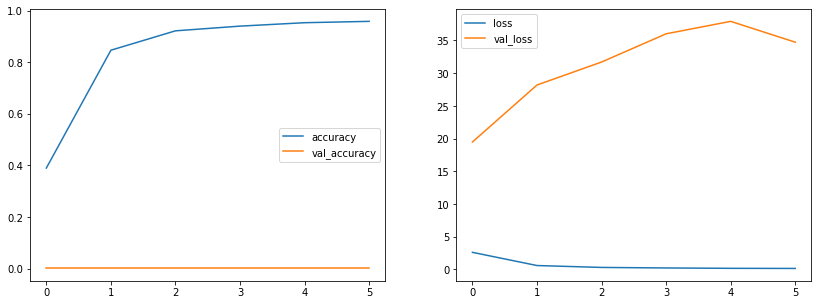

In [25]:
hist_df = pd.DataFrame(hist.history)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
hist_df[["accuracy", "val_accuracy"]].plot(ax=ax[0])
hist_df[["loss", "val_loss"]].plot(ax=ax[1])
plt.show()

In [87]:
model.save("sample_classification_inst.h5")

### Test

In [65]:
y, sr = librosa.load("./test_track/Downtempo_Sexy_Bass_01_1.wav", duration=4)
spt = []
for r in (0, 87, 1):
    ret = librosa.cqt(
        y+((np.random.rand(*y.shape)-0.5)*r if r else r),
        sr,
        hop_length=1024,
        n_bins=24*7,
        bins_per_octave=24
    )
    ret = np.abs(ret)
    spt.append(ret)
    
spt = np.array(spt, np.float32)

C:\Users\spec3\AppData\Local\Temp\ipykernel_51148\1627433265.py:4: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.cqt(


In [67]:
x = np.expand_dims(spt, -1)

In [70]:
np.argmax(model.predict(x))

105

In [75]:
data = []
f = open("./gm.list.txt", "r")
lines = f.readlines()
for line in lines:
    data.append(line.strip())
f.close()

In [80]:
inst_dict = {}
for idx, inst in enumerate(data):
    inst_dict[idx] = inst

In [82]:
inst_dict[105]

'Banjo'

---

In [83]:
y, sr = librosa.load("./test_track/Liverpool_Bass_1.wav", duration=4)
spt = []
for r in (0, 87, 1):
    ret = librosa.cqt(
        y+((np.random.rand(*y.shape)-0.5)*r if r else r),
        sr,
        hop_length=1024,
        n_bins=24*7,
        bins_per_octave=24
    )
    ret = np.abs(ret)
    spt.append(ret)
    
spt = np.array(spt, np.float32)

C:\Users\spec3\AppData\Local\Temp\ipykernel_51148\2187023036.py:4: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ret = librosa.cqt(


In [86]:
inst_dict[np.argmax(model.predict(np.expand_dims(spt, -1)))]

'Alto Sax'